In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

from IPython.display import display

# Filtering and Grouping

In [2]:
def filter_and_visualisation(dataset):
    df = pd.read_csv(f'../Data/dataset_with_readability_{dataset}.csv', keep_default_na=False)
    
    # for balance dataset, get 4000 articles for FA and GA
    if dataset == "(Balance)":
        sample_sizes = {'FA': 4000, 'GA': 4000}
        df = filter_additional_rows(df, sample_sizes)
    
    # see the number of articles for each unique rating
    rate_unique_value = df['rate'].value_counts().reset_index()
    rate_unique_value.columns = ['value', 'counts']
    print("Rate Value Count")
    display(rate_unique_value)
    
    # remove rows with "FL", "Disambig", "Redirect"
    #- FL is just a table
    #- Disambig is a disambiguation page
    #- Redirect does not have any article content
    valid_values = ["FA", "GA", "B", "C", "Start", "Stub"]
    df = df[df['rate'].isin(valid_values)]
    print("Rate Unique Value after cleaning")
    display(list(df['rate'].unique()))
    
    # see the number of articles for each unique importance
    importance_unique_value = df['importance'].value_counts().reset_index()
    importance_unique_value.columns = ['value', 'counts']
    print("Importance Value Count")
    display(importance_unique_value)
    
    # replace NA to Unknown
    df['importance'].replace("NA", "Unknown", inplace=True)
    valid_values = ["Top", "High", "Mid", "Low", "Unknown", "Bottom"]
    df = df[df['importance'].isin(valid_values)] # remove other importance that is not in the list
    
    # see the number of articles for each unique importance AFTER FILTERING
    importance_unique_value = df['importance'].value_counts().reset_index()
    importance_unique_value.columns = ['value', 'counts']
    print("Importance Value Count after cleaning")
    display(importance_unique_value)

    # see the number of articles for each unique rating AFTER FILTERING
    rate_unique_value = df['rate'].value_counts().reset_index()
    rate_unique_value.columns = ['value', 'counts']
    print("Rate Value Count after cleaning")
    display(rate_unique_value)
    
    # separate rate to 2 group [Low, High]
    total_counts, importance_by_class = group_rate(df, dataset)
    
    visualise_rate(rate_unique_value, total_counts)
    visualise_rate_pie(rate_unique_value)
    
    visualise_importance(importance_unique_value)
    visualise_importance_by_class(importance_by_class)
    visualise_importance_by_class_pie(importance_by_class)    

## Sample articles based on rating

In [3]:
def filter_additional_rows(df, sample_sizes):
    """
    sample articles based on the rating
    
    df: dataframe of articles
    sample_sizes: spacial sample size to handle
    """

    sampled_list = []
    
    for value, n in sample_sizes.items():
        if value in df['rate'].unique():
            group = df[df['rate'] == value]
            # sample 4000 or use all if less than 4000 articles
            sampled_list.append(group.sample(n=min(len(group), n), random_state=323))
    
    # sample 2000 articles for the remaining rating
    remaining_values = df[~df['rate'].isin(sample_sizes.keys())]
    sampled_list.append(remaining_values.groupby('rate').apply(lambda x: x.sample(n=min(len(x), 2000), random_state=323)).reset_index(drop=True))

    new_df = pd.concat(sampled_list).reset_index(drop=True)

    return new_df

## Group articles by rating

In [4]:
def group_rate(df, dataset):
    """
    group articles based on the ratings
    count articles in each importance after grouping rate
    
    df: dataframe of articles
    dataset: name of the dataset
    """
    
    if not os.path.exists(f'../Data/grouped_dataset_{dataset}.csv'):
        # convert FA and GA to High and others to Low
        df['2_classes'] = df['rate'].apply(lambda x: 'High' if x in ['FA','GA'] else 'Low')
        df.to_csv(f'../Data/grouped_dataset_{dataset}.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)
    else:
        print("CSV file alreday exists")
        df = pd.read_csv(f'../Data/grouped_dataset_{dataset}.csv', keep_default_na=False)

    # count articles in each importance after grouping rate
    grouped = df.groupby(['2_classes', 'importance']).size().reset_index(name='counts')

    # count number of articles in each group
    total_counts = df['2_classes'].value_counts().reset_index()
    total_counts.columns = ['2_classes', 'total_count']

    # convert the number of articles in each group to percentage
    importance_by_class = grouped.merge(total_counts, on='2_classes')
    importance_by_class['percentage'] = round((importance_by_class['counts'] / importance_by_class['total_count']) * 100,2)

    importance_by_class.drop('total_count',axis=1, inplace=True)
    display(importance_by_class)
    
    return total_counts, importance_by_class

# Visualisation

In [5]:
def visualise_rate(rate_unique_value, total_counts):
    """
    bar chart for number of articles in each rating
    bar chart for number of articles in each group
    
    rate_unique_value: number of articles in each rating
    total_counts: number of articles in each group
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].set_title(f'Frequency of each Rate', fontdict={"fontsize":16}, pad=20)
    axs[0].barh(rate_unique_value['value'], rate_unique_value['counts'])
    _, xmax = axs[0].get_xlim()
    axs[0].set_xlim(0, xmax+300)
    for i, count in enumerate(rate_unique_value['counts']):
        axs[0].annotate(str(count), xy=(count+100, i), va='center')

    axs[1].set_title(f'Frequency of each Rate per Group', fontdict={"fontsize":16}, pad=20)
    axs[1].barh(total_counts['2_classes'], total_counts['total_count'])
    _, xmax = axs[1].get_xlim()
    axs[1].set_xlim(0, xmax+800)
    for i, count in enumerate(total_counts['total_count']):
        axs[1].annotate(str(count), xy=(count+100, i), va='center')
        
    # save image
    if sum(total_counts['total_count']) == 15998:
        image_name = "Rate distribution (Balance)"
    else:
        image_name = "Rate distribution (Imbalance)"
    plt.savefig(f"../Report/appendix/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

In [6]:
def visualise_rate_pie(rate_unique_value):
    """
    draw pie chart for percentage of articles in each rating and group
    
    rate_unique_value: number of articles in each rating
    """
    
    fig, ax = plt.subplots(figsize=(15, 8))

    # get number of articles in each rating within each group
    high_group = list(rate_unique_value.loc[rate_unique_value['value'].isin(['FA', 'GA']), 'counts'])
    low_group = list(rate_unique_value.loc[~rate_unique_value['value'].isin(['FA', 'GA']), 'counts'])
    values = [high_group, low_group]
    size = 0.3
    
    outer_vals = [sum(high_group), sum(low_group)] # get number of articles in each group
    inner_vals = [item for sublist in values for item in sublist]
    
    outer_labels = ["High", "Low"]
    high_labels = list(rate_unique_value.loc[rate_unique_value['value'].isin(['FA', 'GA']), 'value'])
    low_labels = list(rate_unique_value.loc[~rate_unique_value['value'].isin(['FA', 'GA']), 'value'])
    inner_labels = high_labels + low_labels # get all ratings
    
    outer_colors = ["#FFB03A", "#93ACA8"]
    inner_colors = ["#ffd195", "#ffe1ba", 
                    "#9db4b0", "#b3c4c1", "#c8d5d3", "#dee6e4"]
    
    if high_group[0] == 4000:
        title = "Balance Dataset"
    else:
        title = "Imbalance Dataset"
    ax.set_title(f'{title}', fontdict={"fontsize":22}, pad=20)
    
    # outter circle of the pie chart
    wedges_outer, texts_outer, autotexts_outer = ax.pie(outer_vals, radius = 1, 
                                                        autopct='%1.2f%%', startangle=140, textprops={'fontsize':20},
                                                        colors=outer_colors,
                                                        wedgeprops=dict(width=size, edgecolor='w'),
                                                        explode=[0.08, 0])
    
    # inner circle of the pie chart
    wedges_inner, texts_inner, autotexts_inner = ax.pie(inner_vals, radius = 1 - size,
                                                        autopct='%1.2f%%', textprops={'fontsize':13},
                                                        startangle=140,
                                                        colors=inner_colors,
                                                        wedgeprops=dict(width=size, edgecolor='w'),
                                                        explode=[0.1, 0.1, 0, 0, 0, 0])

    # visualisation of the percentage text in outter circle
    for i, autotext in enumerate(autotexts_outer):
        if outer_vals[0] == 8000 and outer_vals[1] == 7998:
            x_adjust = 1.65
            y_adjust = 1
        else:
            x_adjust = 1.4
            y_adjust = 1.1
        angle = (wedges_outer[i].theta2 + wedges_outer[i].theta1) / 2
        x = x_adjust * np.cos(np.radians(angle))  # adjust the factor for radial distance
        y = y_adjust * np.sin(np.radians(angle))  # adjust the factor for radial distance
        autotext.set_position((x, y))
#         autotext.set_fontweight('bold')
        
    # visualisation of the percentage text in inner circle
    for i, autotext in enumerate(autotexts_inner):
        angle = (wedges_inner[i].theta2 + wedges_inner[i].theta1) / 2
        x = 0.3 * np.cos(np.radians(angle))  # adjust the factor for radial distance
        y = 0.3 * np.sin(np.radians(angle))  # adjust the factor for radial distance
        autotext.set_position((x, y))
        
    # visualisation of the group text in outter circle
    for i, label in enumerate(outer_labels):
        if outer_vals[0] == 8000 and outer_vals[1] == 7998:
            y_adjust = 1.2
            x_adjust = 1.65
            if label == 'Low':
                y_adjust = 0.8
        else:   
            y_adjust = 1.45
            x_adjust = 1.4
            if label == 'Low':
                y_adjust = 0.8
        angle = (wedges_outer[i].theta2 + wedges_outer[i].theta1) / 2
        x = x_adjust * np.cos(np.radians(angle))
        y = y_adjust * np.sin(np.radians(angle))
        ax.text(x, y, label, ha='center', va='center', fontsize=26, fontweight='bold', color='black')
    
    # visualisation of the rating text in inner circle
    for i, label in enumerate(inner_labels):
        inwards = 1.5
        if label in high_labels:
            inwards = 1.2
        angle = (wedges_inner[i].theta2 + wedges_inner[i].theta1) / 2
        x = (1 - size*inwards) * np.cos(np.radians(angle))
        y = (1 - size*inwards) * np.sin(np.radians(angle))
        ax.text(x, y, label, ha='center', va='center', fontsize=20, color='black')

    ax.axis('equal')
    
    # save image
    image_name = "Rate Percentage (Imbalance)"
    if high_group[0] == 4000:
        image_name = "Rate Percentage (Balance)"
    plt.savefig(f"../Report/Image/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

In [7]:
def visualise_importance(importance_unique_value):
    """
    bar chart for number of articles in each importance
    pie chart for percentage of articles in each importance
    
    importance_unique_value: number of articles for each unique importance
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].set_title(f'Frequency of each Importance', fontdict={"fontsize":16}, pad=20)
    axs[0].barh(importance_unique_value['value'], importance_unique_value['counts'])
    _, xmax = axs[0].get_xlim()
    axs[0].set_xlim(0, xmax+300)
    for i, count in enumerate(importance_unique_value['counts']):
        axs[0].annotate(str(count), xy=(count+100, i), va='center')

    axs[1].set_title(f'Percentage of each Importance', fontdict={"fontsize":16}, pad=20)
    axs[1].pie(x = importance_unique_value['counts'], labels=importance_unique_value['value'],
               autopct='%1.2f%%', startangle=140, textprops={'fontsize':10},
               colors=sns.color_palette('Set2'),
               explode=[0.03] * importance_unique_value['value'].nunique())
    axs[1].axis('equal')
    
    # save image
    if sum(importance_unique_value['counts']) == 15998:
        image_name = "Importance distribution (Balance)"
    else:
        image_name = "Importance distribution (Imbalance)"
    plt.savefig(f"../Report/appendix/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

In [8]:
def visualise_importance_by_class(importance_by_class):
    """
    bar chart for number of articles in each importance in High an Low group
    
    importance_by_class: number of articles in each importance in both group
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for index, group in enumerate(importance_by_class['2_classes'].unique()):
        data = importance_by_class[importance_by_class['2_classes'] == group]

        axs[index].barh(data['importance'], data['counts'])
        _, xmax = axs[index].get_xlim()
        axs[index].set_xlim(0, xmax+300)
        for i, count in enumerate(data['counts']):
            axs[index].annotate(str(count), xy=(count+(index*100), i), va='center')
        axs[index].set_title(f'Frequency of each importance in {group} quality', fontdict={"fontsize":16}, pad=20)
        
    # save image
    if sum(importance_by_class['counts']) == 15998:
        image_name = "Importance by class (Balance)"
    else:
        image_name = "Importance by class (Imbalance)"
    plt.savefig(f"../Report/appendix/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

In [9]:
def visualise_importance_by_class_pie(importance_by_class):
    """
    pie chart for percentage of articles in each importance in High an Low group
    
    importance_by_class: number of articles in each importance in both group
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for index, group in enumerate(importance_by_class['2_classes'].unique()):
        data = importance_by_class[importance_by_class['2_classes'] == group]

        axs[index].pie(x = data['percentage'], labels=data['importance'], 
                       autopct='%1.2f%%', startangle=140, textprops={'fontsize':12},
                       colors=sns.color_palette('Set2'),
                       explode=[0.03] * data['percentage'].nunique())
        axs[index].set_title(f'Percentage of each Importance in {group} quality', fontdict={"fontsize":16}, pad=20)
        axs[index].axis('equal')
        
    # save image
    if sum(importance_by_class['counts']) == 15998:
        image_name = "Importance by class pie (Balance)"
    else:
        image_name = "Importance by class pie (Imbalance)"
    plt.savefig(f"../Report/appendix/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

# Imbalance Class

Rate Value Count


,value,counts
0,C,5364
1,Start,4436
2,B,3816
3,List,2412
4,Stub,736
5,Disambig,683
6,GA,672
7,Redirect,580
8,FA,379
9,,76


Rate Unique Value after cleaning


['GA', 'B', 'C', 'Start', 'FA', 'Stub']

Importance Value Count


,value,counts
0,Mid,4057
1,Low,3985
2,High,3544
3,Top,2156
4,Unknown,1657
5,Bottom,4


Importance Value Count after cleaning


C:\Users\khais\AppData\Local\Temp\ipykernel_14568\1907863363.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['importance'].replace("NA", "Unknown", inplace=True)


,value,counts
0,Mid,4057
1,Low,3985
2,High,3544
3,Top,2156
4,Unknown,1657
5,Bottom,4


Rate Value Count after cleaning


,value,counts
0,C,5364
1,Start,4436
2,B,3816
3,Stub,736
4,GA,672
5,FA,379


CSV file alreday exists


,2_classes,importance,counts,percentage
0,High,High,302,28.73
1,High,Low,200,19.03
2,High,Mid,304,28.92
3,High,Top,204,19.41
4,High,Unknown,41,3.90
5,Low,Bottom,4,0.03
6,Low,High,3242,22.59
7,Low,Low,3785,26.37
8,Low,Mid,3753,26.15
9,Low,Top,1952,13.60


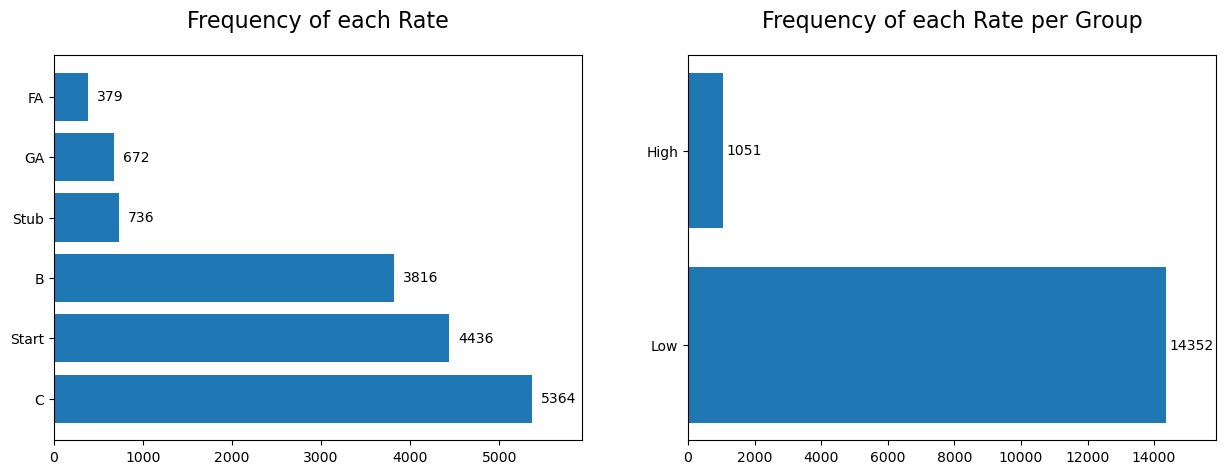

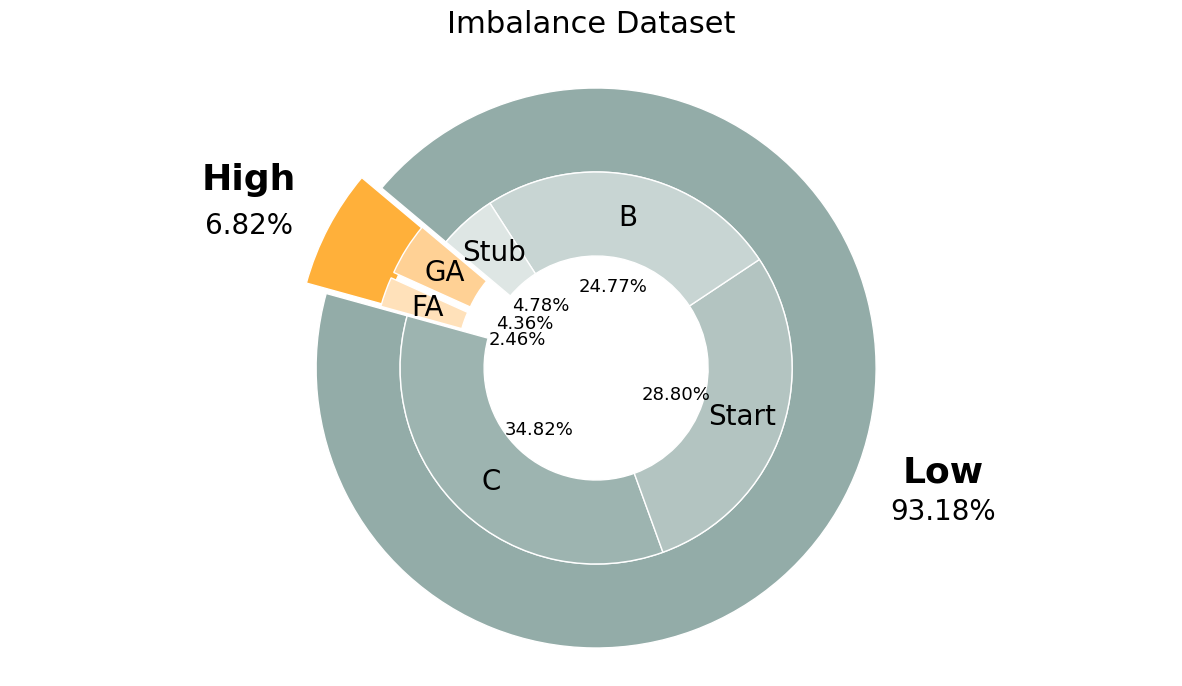

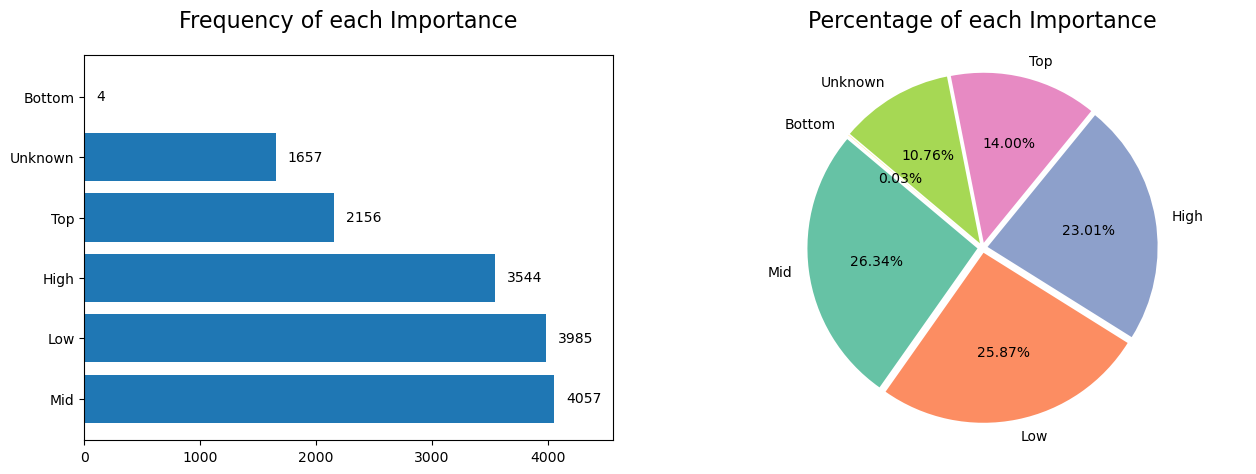

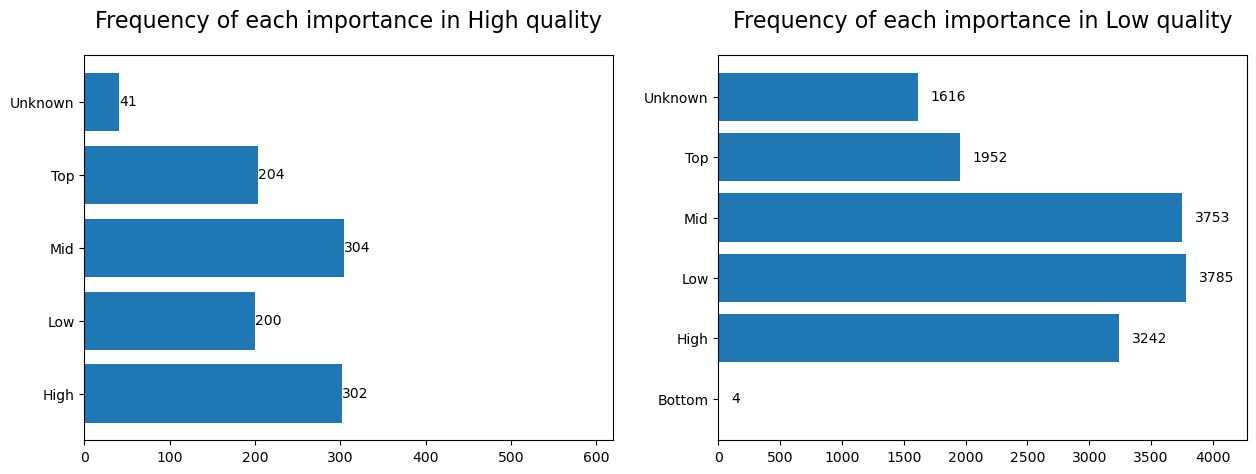

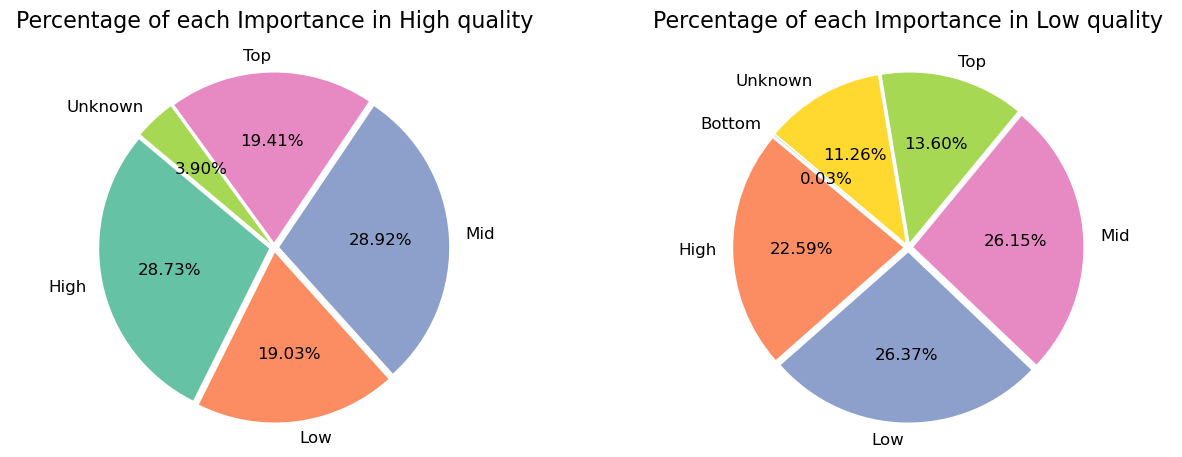

In [10]:
filter_and_visualisation("(Imbalance)")

# Balance Data

Rate Value Count


C:\Users\khais\AppData\Local\Temp\ipykernel_14568\2742473404.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_list.append(remaining_values.groupby('rate').apply(lambda x: x.sample(n=min(len(x), 2000), random_state=323)).reset_index(drop=True))


,value,counts
0,FA,4000
1,GA,4000
2,B,2000
3,C,2000
4,Start,2000
5,Stub,2000


Rate Unique Value after cleaning


['FA', 'GA', 'B', 'C', 'Start', 'Stub']

Importance Value Count


,value,counts
0,Low,5147
1,NA,4927
2,Mid,2324
3,Top,2006
4,High,1372
5,Unknown,220
6,Bottom,2
7,Related,2


Importance Value Count after cleaning


C:\Users\khais\AppData\Local\Temp\ipykernel_14568\1907863363.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['importance'].replace("NA", "Unknown", inplace=True)


,value,counts
0,Low,5147
1,Unknown,5147
2,Mid,2324
3,Top,2006
4,High,1372
5,Bottom,2


Rate Value Count after cleaning


,value,counts
0,FA,4000
1,GA,4000
2,C,2000
3,Stub,2000
4,B,1999
5,Start,1999


CSV file alreday exists


,2_classes,importance,counts,percentage
0,High,Bottom,2,0.02
1,High,High,632,7.90
2,High,Low,4756,59.45
3,High,Mid,1814,22.68
4,High,Top,180,2.25
5,High,Unknown,616,7.70
6,Low,High,740,9.25
7,Low,Low,391,4.89
8,Low,Mid,510,6.38
9,Low,Top,1826,22.83


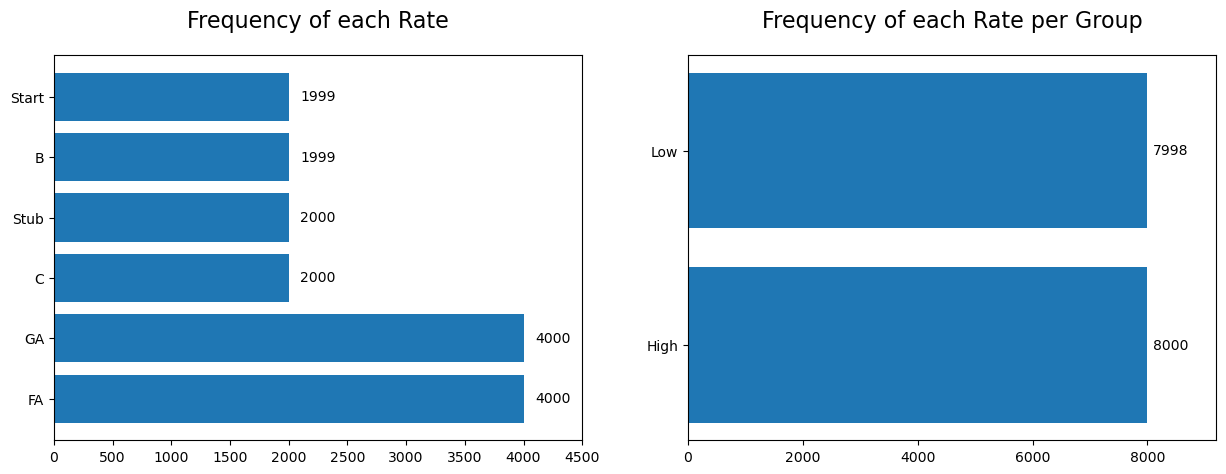

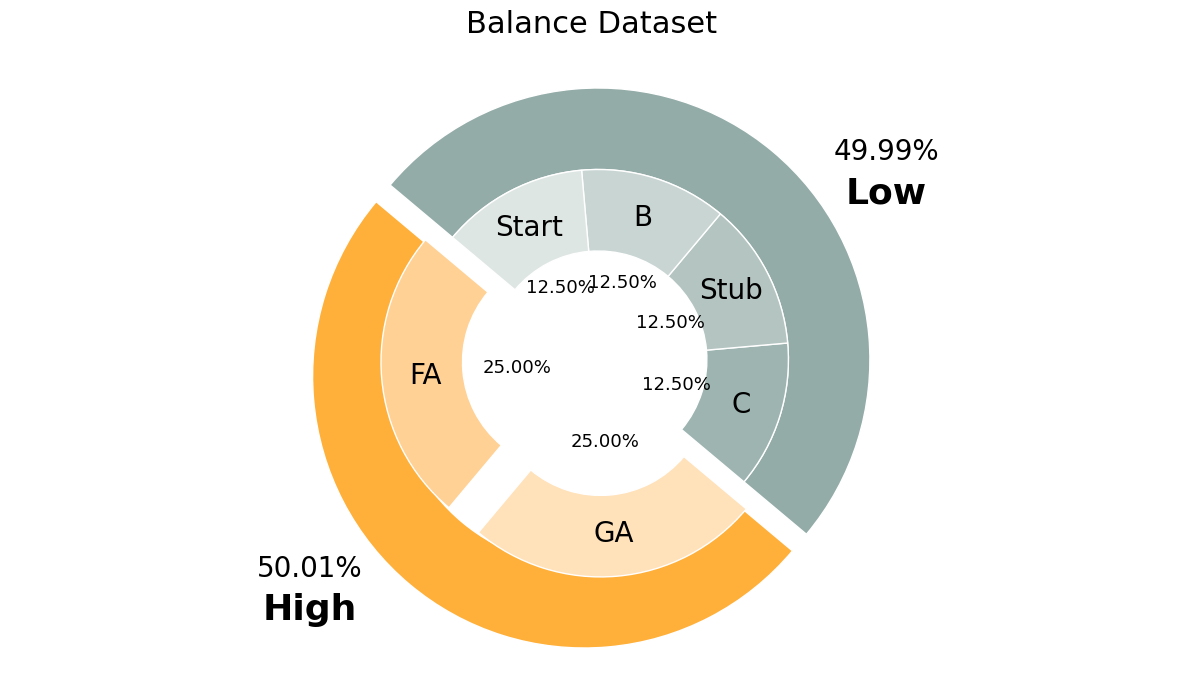

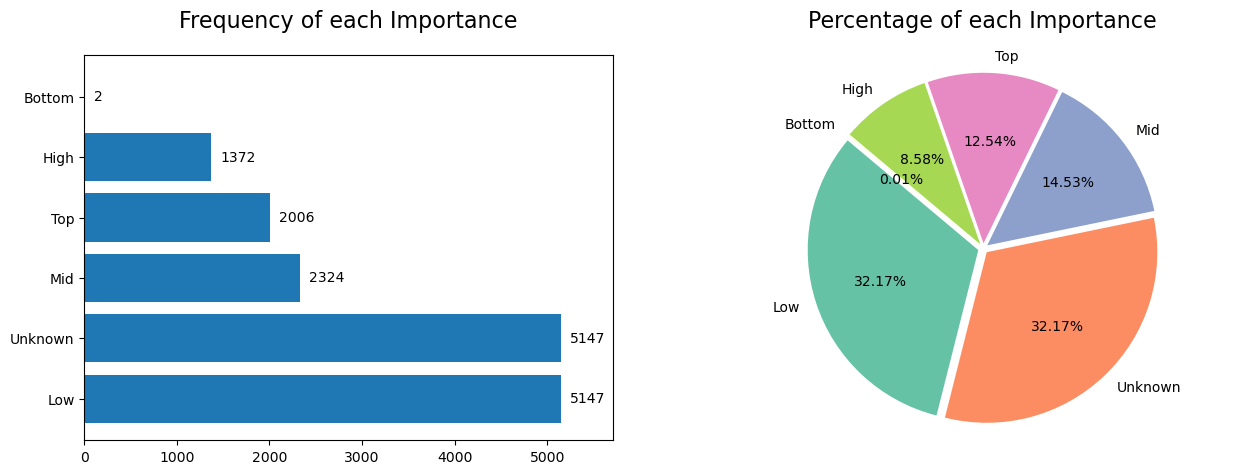

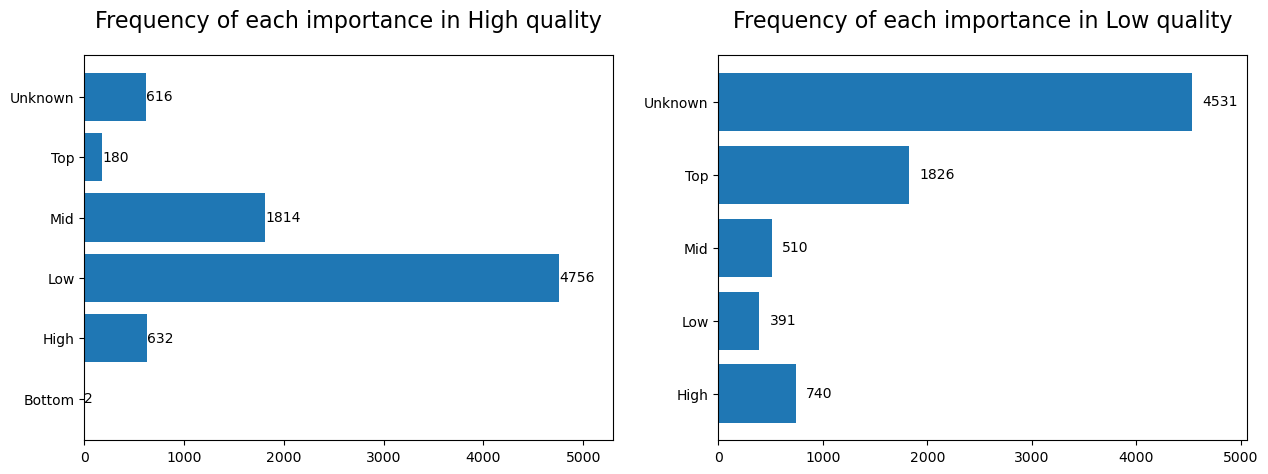

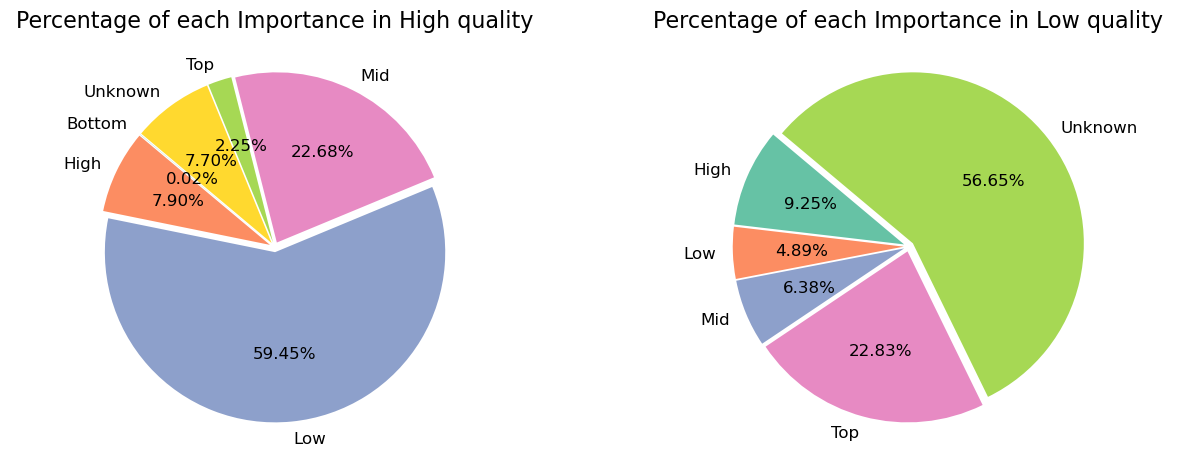

In [11]:
filter_and_visualisation("(Balance)")